Index(['10 things I hate about you (1999)', '12 Monkeys (1995)',
       '13 going on 30 (2004)', '21 Grams (2003)', '25th hour (2002)',
       '28 days later (2002)', '3000 Miles to Graceland (2001)',
       '8 Mile (2002)', 'A Night at the Roxbury (1998) ',
       'A time to kill (1996)',
       ...
       'Toy Story (1995)', 'Toy Story 2 (1999)', 'Unforgiven (1992)',
       'What Lies Beneath (2000)', 'What Women Want (2000)',
       'Wild Wild West (1999)', 'Wing Commander (1999)', 'X-Men (2000)',
       'X2 (2003)', 'Zoolander (2001)'],
      dtype='object', length=209)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   120 non-null    float64
 1   X1      120 non-null    int64  
 2   X2      120 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 2.9 KB
                sum_sq     df             F        PR(>F)
X1        2.999991e+01

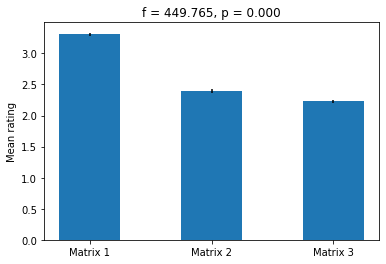

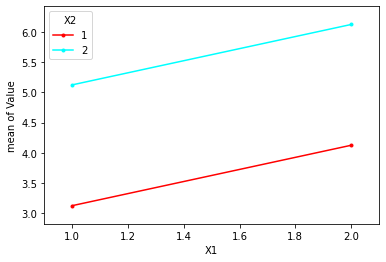

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# ### Lab04
# 
# ### 2021-09-23

# ### Statistical significance tests on real data


#%% In this script, we will analyze real data from a published article (Wallisch & Whritner 2017)
# A subset of it. The point is specifically to illustrate hypothesis testing 
# in Python and to implement the Canonical Data Analysis cascade. 
# The advantage of this is that you'll be free of the limitations of canned
# packages like Excel or SPSS. 
# Specifically, we will test the hypothesis that Matrix I was the best of
# the Matrix movies (it's a trilogy). 
                    
# Since we are doing this here, let me walk you through the null hypothesis
# testing framework at least once (just once). It is a bit arcane. It made
# sense to Fisher.                  
                    
# 1) Start with a hypothesis (something about the world you would wish to
# know, whether it is true or not. The participants are just the unit of 
# analysis that gives you the data). 

# 2) State a null hypothesis and assume that it is 100% true (that there is
# no difference in the conditions of 1), e.g. here Matrix I rated the same
# as Matrix II and III). This is essential to NHST. 

# 3) This is - at the face of it - an odd thing to do, because naively you
# would think that scientists look for probability (Hypothesis | Data) 
# But that is unknowable. Which is why we do the study in the first place
# What is calculable: Probability (Data | NULL hypothesis)
# You can assess the probability of the data given the null hypothesis

# 4) To get this probability, we represent the sample by a parameter like a 
# sample mean, then transform the sample mean into a test statistic with a 
# known distribution.

# 5) The area under the curve of the distribution of the test statistic in
# the tail (or tails, if it is a 2-tailed test) is the p value, in other
# words the probability of this result (or a more extreme one) given chance
# alone.

# 6) We compare the p value to a significance level alpha (typically 5% or 1%)

# 7) Decision point (Choice)
# a) If it is smaller than that, we decide to reject our assumption that the 
# null hypothesis is true.
# b) If it is not smaller than that, we don't do anything because we already
# assumed that the null hypothesis is true.                    
                    
# Paraphrased logic, in english: We acknowledge any outcome could be due to
# chance. Our only question is how likely that is by chance. If it is
# implausibly unlikely, we reject the assumption that it was just due to
# chance. And either the null hypothesis is true or not, so if we reject it
# is plausible, it probably means that our treatment did have an effect.                  
                    
#%% Before we do the stats, let's talk about the psychology of movie ratings:
    
# Hypothesis 1: First is best. Because that's usually true for trilogies
# (with the exception of Star Wars). That's probably true just because of
# regression to the mean. Also expectations. If the first one is great, it's
# hard to beat expectations. 

# Hypothesis 2: Ratings for later ones will be even better. Production
# qualities improve over time. Also, only fans might watch all of them.
# People who didn't like the 1st one might drop out and never watch the
# other ones, so the RATINGS might appear higher. 

# Make sure that you actually have 2 plausible outcomes before doing the
# study. If the outcome is a foregone conclusion, it's not science. Science
# is about being open to any possible outcome.

# Null hypothesis: There is no difference. 

# Let's implement the canonical data analysis cascade

#%% 0 Init (Birth)

# a. Predispositions:
startColumn = 177 # This is the column that contains data from matrix I
# matrix II is column 178 and matrix III is column 179
numMovies = 3 # Data from how many movies (it's a trilogy)
pruningMode = 2 # This flag determines how we will remove nans. It's important to be mindful of this 
# 1 = element-wise, 2 = row-wise, 3 = imputation

# b. Load/import - libraries/packages:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

#%% 1 Loader / Transducer: 
# Taking the inputs from their native form and putting it into 
# something Python can use: a matrix

data = np.genfromtxt('movieRatingsDeidentified.csv', delimiter = ',', skip_header = 1)
# We want just the data, so skip the first row / header
dataMatrix = data[:,startColumn:startColumn+numMovies] # Should yield a n x 3 matrix

# Decompose data_matrix into separate arrays, one for each movie:
M1 = dataMatrix[:,0]
M2 = dataMatrix[:,1]
M3 = dataMatrix[:,2]
# They are all the same length because if the participant did not respond
# the element is represented with NaN

#%% 2 "Thalamus" stage: We need to get rid of "bad" data. 

# This is not data we don't like the results of. 
# It's data that if it entered the analysis stream would ruin our analysis

# By visual inspection, the matrix of movie ratings contains numbers from 1
# to 4, representing "star ratings", and "nans". 
# What could the nans be? What do they mean?
# It could be people not doing the task. There are many ways to detect this.
# People who press buttons not in the instructions, people responding too
# fast, people responding too slow. 

# Why might "too slow" be a problem? In one study, we were interested in
# reaction time as a dependent variable. But once, a participant went to the
# restroom in the middle of the experiment and didn't come back for 30
# minutes. What would happen to the mean reaction time for the condition
# that the trial was in, in which this participant used the restroom. If we
# included this, it would be meaningless. The mean is sensitive to outliers.
# The rest of the reactions are in milli-seconds. This is 4 orders of
# magnitude higher. Another example from neuroscience: Voltages of
# electrodes are usually in mV or microV (depending on eeg vs.
# microelectrode). What if for one trial there was voltage surge that hit
# the building - all measurements from that trial are invalid. You need to
# exclude that BEFORE looking at the results. All results will be thrown off
# by that.

# Given that these are movie ratings, it is not implausible that most of
# these nans represent missing data due to the participant did not watch the
# movie in question. 
# The reason we have to deal with this is that once this data is in the
# analysis stream, it will make the rest of the interpretation hard. If
# there is a single nan in the data, we can't take the mean. 
# So "filtering" or removing of ill-formed data will mean "removal of
# missing data" in this case.
# But here is the catch: Remove them how?

# There are at least 3 ways to handle this, and depending on how we do this,
# it will set up the entire rest of the analysis (and what it means). 

# 1) Element-wise removal of nans: We remove nans from each data matrix
# where we find it. But we are starting with an equal n for each movie. 3204
# rows in all 3 matrices. Once we start removing stuff element-wise, due to
# the fact that there are an unequal number of nans for each movie, this
# will result in unequal n, which will make some analyses impossible. Some
# analyses presume equal n. It could also introduce bias. If we remove
# people who have not seen the latter ones, but that was a choice (their
# choice), we would inflate the ratings artificially. 

# 2) Row-wise (participant-wise) removal of nans: If a participant has not
# seen even one of the movies, we remove all of the data from this
# participant. Good: We keep n the same. Bad: We will lose a lot of data.
# Probably most of the data. This usually looks suspicious, also: Loss of
# statistical power. 

# 3) Imputation: We replace the missing data with our guess of what the 
# rating would have been, if there had been a rating. 
# This is more commonly done in engineering than in science. 
# Sometimes, people replace the missing value with the mean. But which mean?
# The participant-wise mean or the movie-wise mean - or a blend of the two? 
# We could do the average of the movie, but is that fair? Those people chose
# not to watch it - they were not randomly assigned to watch the movies.
# This suggests that their rating would have been lower than that average.
# But how much lower? 0? Probably too extreme. 
# In science, data only comes from measurement

# In real life, pick the option that makes the most sense for your
# theoretical approach, and just do that. For teaching purposes, we'll do
# all of them, just so you see how that plays out in real life.

# 1) Element-wise:
if pruningMode == 1:
   M1 = M1[np.isfinite(M1)] # only keep the finite elements (not infinity or NaN)
   M2 = M2[np.isfinite(M2)] # only keep the finite elements (not infinity or NaN)
   M3 = M3[np.isfinite(M3)] # only keep the finite elements (not infinity or NaN)
# Outcome: Exactly as we suspected, n is unequal now, and we have concerns
# about the psychological interpretation of this, as we only have the
# ratings of die-hard fans who watched all 3 for the third one.

# 2) Row wise:
elif pruningMode == 2:
    temp = np.array([np.isnan(M1),np.isnan(M2),np.isnan(M3)],dtype=bool)
    temp2 = temp*1 # convert boolean to int
    temp2 = sum(temp2) # take sum of each participant
    missingData = np.where(temp2>0) # find participants with missing data
    M1 = np.delete(M1,missingData) # delete missing data from array
    M2 = np.delete(M2,missingData) # delete missing data from array
    M3 = np.delete(M3,missingData) # delete missing data from array
# Good: We have equal n now. 
# Bad: We only have 1493 out of 3204 we started with left
# That is a) suspicious, b) we lost a lot of power

#%% 3 Reformatting - V1: Format data into a representation to work with

# I did most of the work for you already. In preprocessing. In other words,
# I took the records that came in over time by participant and broke them
# up, so they are now ordered by movie. I already abstracted over time.
# There is still something we can do that will make our life easier, which
# is to put this into a format we can loop over (to do all these tests). Why
# is the current format not great? M1 vs. M3, etc. is not great for that?
# Wouldn't it be better to have a matrix "DATA" that contains all 3 movies?
# It would be. Why can't it be a matrix now, given we removed missing data
# element-wise? Because n is unequal. So let's make it an array of arrays

if pruningMode == 1:
    combinedData = np.transpose(np.array([M1,M2,M3])) # array of arrays
elif pruningMode == 2:
    combinedData = np.transpose(np.array([M1,M2,M3])) # 2D array
    # We can now put the data into a 2D array because we have an equal number
    # of rows for M1, M2 and M3
    
#%% 4a) Extrastriate cortex: Doing the actual specialized analyses
# Descriptive statistics - we are looking for very special numbers that
# capture the essence of the entire dataset - the typical number (central
# tendency) and the dispersion. Typically mean and SD. 

# Initialize container to store descriptives:
descriptivesContainer = np.empty([numMovies,4])
descriptivesContainer[:] = np.NaN 

# 1. Element-wise:
if pruningMode == 1:
    for ii in range(numMovies):
        descriptivesContainer[ii,0] = np.mean(combinedData[ii]) # mu
        descriptivesContainer[ii,1] = np.std(combinedData[ii]) # sigma
        descriptivesContainer[ii,2] = len(combinedData[ii]) # n
        descriptivesContainer[ii,3] = descriptivesContainer[ii,1]/np.sqrt(descriptivesContainer[ii,2]) # sem

# 2. Row-wise:
elif pruningMode == 2:
    for ii in range(numMovies):
        descriptivesContainer[ii,0] = np.mean(combinedData[:,ii]) # mu
        descriptivesContainer[ii,1] = np.std(combinedData[:,ii]) # sigma
        descriptivesContainer[ii,2] = len(combinedData[:,ii]) # n
        descriptivesContainer[ii,3] = descriptivesContainer[ii,1]/np.sqrt(descriptivesContainer[ii,2]) # sem
        
#%% 4b) Extrastriate cortex part II: Inferential statistics

# So far, so good. The mean rating of matrix 1 is higher than that of matrix
# 2, and the mean of matrix 2 is higher than matrix 3. 

# The question here is whether the differences we saw in the descriptives -
# usually the means - are "statistically significant". 
# Whether it is plausibly consistent with chance (that the numbers came out
# of a RGN)

# 1) Assert a null hypothesis: We assume that the data came out of a RNG -
# strictly by chance.

# 2) We compute the probability that this is the case - assuming chance. 

# 3) If this probability is implausibly low, we DECIDE to concede that we
# were wrong in 1) - that it is probably not solely due to chance. 

# It's a choice, it's a decision. You have not falsified the null hypothesis
# or "proven" to be wrong. We made a choice that it is implausible. But we
# could be wrong (type I and type II errors). 

# In science, we consider things that happen only 1 in 20 times to be "too
# implausible" to be consistent with chance. This corresponds to getting
# heads (or tails) 5 times in a row (if you flip coins). Is that terribly
# implausible? There is now a movement afoot to lower this to 1 in 200. To
# avoid false positives. So results won't reproduce. This gave p values a
# bad reputation. But there is nothing wrong with them, if they are
# understood and used properly. Properly = conservative enough criterion of
# implausibility and high enough power. 

# So our question now is: Assuming that there is no difference in reality, how
# likely is it to get this mean difference just by chance (sampling error).    

# Analogy: We are doing a crime scene investigation. Null hypothesis is the
# presumption of innocence. We only reject that presumption if forced by the
# data (in other words, if the evidence suggests that the fingerprints, DNA,
# etc.) of the suspect didn't just get there by chance. It is always
# possible. The unreasonable doubt (that your evidence got there just by
# chance always persists). 

# We need to do a t-test because we want to assess how likely this observed
# mean difference is and we do not know the population parameters. We have
# to do an independent samples t-test because we eliminated missing data in a 
# way to yield unequal n. We have no choice (if we want to do a t-test)

# 1. Element-wise:
if pruningMode == 1:
    t1,p1 = stats.ttest_ind(combinedData[0],combinedData[1])
    # There is a significant difference. 
    # In english: The difference between the samples (specifically the sample 
    # means) is too large to be reasonably consistent with chance. 

    # Now let's compute the degrees of freedom (N1 + N2 - 2):
    df = int(descriptivesContainer[0,2] + descriptivesContainer[1,2] - 2)

    # How likely was our mean difference assuming chance? 
    # The p-value is really small. 5% is an extremely liberal threshold.
    # p-values of real effects are very close to 0, if you have sufficient
    # power. They are distributed as a beta-distribution. Like this one.

    # Degrees of freedom for an independent samples t-test is:
    # Sample size1 + sample size2 - 2 (2 because we calculate 2 sample means and
    # we lose 1 df per sample mean). So the general equation for df is not n -
    # 1, it is n - k. 

    # The independent samples t-test is the only one we can do, once we have
    # unequal n, but is it the right test? Did the data about the 2 movies come
    # from different populations? No. They are the same people. In reality, we
    # probably have much less df. 

    # Mean of Matrix 2 and 3 seem rather close. Question: Plausibly due to chance
    # (sampling error) alone?
    t2,p2 = stats.ttest_ind(combinedData[1],combinedData[2])

    # We can do as many t-tests as we want. We will have to adjust the
    # alpha-level from 0.05 to 0.05/c, where c is the number of tests
    # (comparisons), that's called the "Bonferroni correction". 

    # Even this comparison is significant, even after the Bonferroni correction,
    # so we conclude that this observed difference in ratings is not due to
    # chance alone. In other words, Matrix 2 is a better movie than Matrix 3. 
    # Expectation: The p-value will be even lower than 1 vs. 2, because the
    # mean difference is larger, but it might not be, because the df will be
    # less (fewer people saw M3). The p value comes from the t-value in light of
    # the df (because the t-distribution is a family of distributions which
    # differs as df - that's a parameter).
    t3,p3 = stats.ttest_ind(combinedData[0],combinedData[2])

    # Do this with ANOVA - allows to compare more than 2 sample means without 
    # inflating alpha (from multiple comparisons)
    f,p = stats.f_oneway(combinedData[0],combinedData[1],combinedData[2])
    
    # Nonparametric tests equivalent to t-tests - Mann-Whitney U test:
    # Test for comparing medians of ordinal data (such as movie ratings)
    # from 2 groups
    u1,p1 = stats.mannwhitneyu(combinedData[0],combinedData[1])
    u2,p2 = stats.mannwhitneyu(combinedData[0],combinedData[2])
    u3,p3 = stats.mannwhitneyu(combinedData[1],combinedData[2])

    # Nonparametric tests equivalent to ANOVA - Kruskal-Wallis:
    # Same assumptions as above, but for more than 2 groups
    h,p = stats.kruskal(combinedData[0],combinedData[1])
    
    

# These are not different people. So we have to do a "within subjects"
# design (repeated measures) - in other words do a paired samples t-test. 
# But to do that, we need to do row-wise removal of missing data 

# 2. Row-wise:
elif pruningMode == 2:
    # Because our n's are now equal, we can now do a t-test for dependent
    # groups (which is much more appropriate, because our data came from the
    # *same* people, the groups WERE dependent, we previously inflated df)
    t1,p1 = stats.ttest_rel(combinedData[:,0],combinedData[:,1])
    df = len(combinedData) - 1
    # Df HERE is now n-1, because the t-test for dependent groups first
    # converts all scores to differences, then takes ONE mean, so we only
    # lose 1 df. Overall, we have much fewer df, than in the independent
    # samples t-test.
    # The p-value is even lower. How is that possible, given that df is
    # lower too? 
    # In an independent samples t-test individual differences (some people
    # just don't like anything, or everything) all goes into the
    # denominator, in other words is interpreted as error. That lowers the
    # t-value. In a paired-samples t-test, everyone is their own control. So
    # the individual differences go away. In english: A paired samples
    # t-test is usually much more powerful, even if the df is lower. So you
    # should do this one, whenever you can. 
    t2,p2 = stats.ttest_rel(combinedData[:,1],combinedData[:,2])
    t3,p3 = stats.ttest_rel(combinedData[:,0],combinedData[:,2])
    
    # Let's do an ANOVA instead:
    f,p = stats.f_oneway(combinedData[:,0],combinedData[:,1],combinedData[:,2])
    
#%% 5 Motor cortex: Plot the data 
# Here we are going to plot the data from our ANOVA and add a title
# that contains the f- and p-values

# First, let's run our ANOVA once again:
if pruningMode == 1:
    f,p = stats.f_oneway(combinedData[0],combinedData[1],combinedData[2])
elif pruningMode == 2:
    f,p = stats.f_oneway(combinedData[:,0],combinedData[:,1],combinedData[:,2])
    
# Now, let's plot it:
x = ['Matrix 1', 'Matrix 2', 'Matrix 3'] # labels for the bars
xPos = np.array([1,2,3]) # x-values for the bars
plt.bar(xPos,descriptivesContainer[:,0],width=0.5,yerr=descriptivesContainer[:,3]) # bars + error  
plt.xticks(xPos, x) # label the x_pos with the labels
plt.ylabel('Mean rating') # add y-label
plt.title('f = {:.3f}'.format(f) + ', p = {:.3f}'.format(p)) # title is the test stat and p-value
# Note: we round our p-value to the nearest thousandth, which in our case is 0.000
# In reality, it is much smaller than that. Instead, we could have chosen to use
# scientific notation in our title. More on that later.

#%% Supplementary material 1: Representing the data with a Pandas dataframe and doing a 2-way ANOVA in Python and make an ANOVA table (and a means plot)

import pandas as pd

# 1. Load data:
df = pd.read_csv('movieRatingsDeidentified.csv',skipinitialspace=True)
# Fill empty strings with NaN
# Now we have the headers AND the data in one object
# This is a DataFrame. For handling tabular data.

# 2. Let's get a handle on our movie titles:
titles = df.columns 
print(titles)
# We won't use this for subsequent analyses, but it's nice to see all the titles at once

# 3. Find the Matrix data:
title = 'Matrix' # or any other title, for that matter
theMatrix = df.loc[:,df.columns.str.contains(title)]

# 4. Perform descriptives:
magic = theMatrix.describe()
# We don't have to run a loop or initialize a container
# We are still missing the SEM, so let's add it:
temp = magic.iloc[2,:]/np.sqrt(magic.iloc[0,:])
magic.loc['sem'] = temp

#%% Supplementary material 2: Do a two-way ANOVA and show an ANOVA table

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot as meansPlot

df = pd.read_csv('twoWayAnovaExample.csv',skipinitialspace=True) # load new data set
df.info() # What is the structure of the data frame?

model = ols('Value ~ X1 + X2 + X1:X2', data=df).fit() #Build the two-way ANOVA model. Value = y, X1,X2 = Main effects. X1:X2 = interaction effect
anova_table = sm.stats.anova_lm(model, typ=2) #Create the ANOVA table. Residual = Within
print(anova_table) #Show the ANOVA table

#Show the corresponding means plot
fig = meansPlot(x=df['X1'], trace=df['X2'], response=df['Value'])



In [27]:
# a. Predispositions:
startColumn = 177 # This is the column that contains data from matrix I
# matrix II is column 178 and matrix III is column 179
numMovies = 3 # Data from how many movies (it's a trilogy)
pruningMode = 2 # This flag determines how we will remove nans. It's important to be mindful of this 
# 1 = element-wise, 2 = row-wise, 3 = imputation

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

#%% 1 Loader / Transducer: 
# Taking the inputs from their native form and putting it into 
# something Python can use: a matrix

data = np.genfromtxt('movieRatingsDeidentified.csv', delimiter = ',', skip_header = 1)
# We want just the data, so skip the first row / header
dataMatrix = data[:,startColumn:startColumn+numMovies] # Should yield a n x 3 matrix

# Decompose data_matrix into separate arrays, one for each movie:
M1 = dataMatrix[:,0]
M2 = dataMatrix[:,1]
M3 = dataMatrix[:,2]

In [40]:
# 1) Element-wise:
if pruningMode == 1:
   M1 = M1[np.isfinite(M1)] # only keep the finite elements (not infinity or NaN)
   M2 = M2[np.isfinite(M2)] # only keep the finite elements (not infinity or NaN)
   M3 = M3[np.isfinite(M3)] # only keep the finite elements (not infinity or NaN)
# Outcome: Exactly as we suspected, n is unequal now, and we have concerns
# about the psychological interpretation of this, as we only have the
# ratings of die-hard fans who watched all 3 for the third one.

# 2) Row wise:
elif pruningMode == 2:
    temp = np.array([np.isnan(M1),np.isnan(M2),np.isnan(M3)],dtype=bool)
    temp2 = temp*1 # convert boolean to int
    temp2 = sum(temp2) # take sum of each participant
    missingData = np.where(temp2>0) # find participants with missing data
    M1 = np.delete(M1,missingData) # delete missing data from array
    M2 = np.delete(M2,missingData) # delete missing data from array
    M3 = np.delete(M3,missingData) # delete missing data from array

In [41]:
if pruningMode == 1:
    combinedData = np.transpose(np.array([M1,M2,M3])) # array of arrays
elif pruningMode == 2:
    combinedData = np.transpose(np.array([M1,M2,M3])) # 2D array
    # We can now put the data into a 2D array because we have an equal number
    # of rows for M1, M2 and M3
    

In [42]:
combinedData[0], combinedData[1]


(array([3.5, 0.5, 0.5]), array([4., 4., 4.]))

In [43]:
combinedData[0].shape, combinedData[1].shape


((3,), (3,))

In [44]:
u1, p1 = stats.mannwhitneyu(combinedData[0],combinedData[1])
u1, p1


(0.0, 0.05934643879191985)

In [74]:
# Initialize container to store descriptives:
descriptivesContainer = np.empty([numMovies,4])
descriptivesContainer[:] = np.NaN 

# 1. Element-wise:
if pruningMode == 1:
    for ii in range(numMovies):
        descriptivesContainer[ii,0] = np.mean(combinedData[ii]) # mu
        descriptivesContainer[ii,1] = np.std(combinedData[ii]) # sigma
        descriptivesContainer[ii,2] = len(combinedData[ii]) # n
        descriptivesContainer[ii,3] = descriptivesContainer[ii,1]/np.sqrt(descriptivesContainer[ii,2]) # sem

# 2. Row-wise:
elif pruningMode == 2:
    for ii in range(numMovies):
        descriptivesContainer[ii,0] = np.mean(combinedData[:,ii]) # mu
        descriptivesContainer[ii,1] = np.std(combinedData[:,ii]) # sigma
        descriptivesContainer[ii,2] = len(combinedData[:,ii]) # n
        descriptivesContainer[ii,3] = descriptivesContainer[ii,1]/np.sqrt(descriptivesContainer[ii,2]) # sem
        
        

In [77]:
# 1. Element-wise:
if pruningMode == 1:
    t1,p1 = stats.ttest_ind(combinedData[0],combinedData[1])
    # There is a significant difference. 
    # In english: The difference between the samples (specifically the sample 
    # means) is too large to be reasonably consistent with chance. 

    # Now let's compute the degrees of freedom (N1 + N2 - 2):
    df = int(descriptivesContainer[0,2] + descriptivesContainer[1,2] - 2)

    # How likely was our mean difference assuming chance? 
    # The p-value is really small. 5% is an extremely liberal threshold.
    # p-values of real effects are very close to 0, if you have sufficient
    # power. They are distributed as a beta-distribution. Like this one.

    # Degrees of freedom for an independent samples t-test is:
    # Sample size1 + sample size2 - 2 (2 because we calculate 2 sample means and
    # we lose 1 df per sample mean). So the general equation for df is not n -
    # 1, it is n - k. 

    # The independent samples t-test is the only one we can do, once we have
    # unequal n, but is it the right test? Did the data about the 2 movies come
    # from different populations? No. They are the same people. In reality, we
    # probably have much less df. 

    # Mean of Matrix 2 and 3 seem rather close. Question: Plausibly due to chance
    # (sampling error) alone?
    t2,p2 = stats.ttest_ind(combinedData[1],combinedData[2])

    # We can do as many t-tests as we want. We will have to adjust the
    # alpha-level from 0.05 to 0.05/c, where c is the number of tests
    # (comparisons), that's called the "Bonferroni correction". 

    # Even this comparison is significant, even after the Bonferroni correction,
    # so we conclude that this observed difference in ratings is not due to
    # chance alone. In other words, Matrix 2 is a better movie than Matrix 3. 
    # Expectation: The p-value will be even lower than 1 vs. 2, because the
    # mean difference is larger, but it might not be, because the df will be
    # less (fewer people saw M3). The p value comes from the t-value in light of
    # the df (because the t-distribution is a family of distributions which
    # differs as df - that's a parameter).
    t3,p3 = stats.ttest_ind(combinedData[0],combinedData[2])

    # Do this with ANOVA - allows to compare more than 2 sample means without 
    # inflating alpha (from multiple comparisons)
    f,p = stats.f_oneway(combinedData[0],combinedData[1],combinedData[2])
    
    # Nonparametric tests equivalent to t-tests - Mann-Whitney U test:
    # Test for comparing medians of ordinal data (such as movie ratings)
    # from 2 groups
    u1,p1 = stats.mannwhitneyu(combinedData[0],combinedData[1])
    u2,p2 = stats.mannwhitneyu(combinedData[0],combinedData[2])
    u3,p3 = stats.mannwhitneyu(combinedData[1],combinedData[2])

    # Nonparametric tests equivalent to ANOVA - Kruskal-Wallis:
    # Same assumptions as above, but for more than 2 groups
    h,p = stats.kruskal(combinedData[0],combinedData[1])
    
    

# These are not different people. So we have to do a "within subjects"
# design (repeated measures) - in other words do a paired samples t-test. 
# But to do that, we need to do row-wise removal of missing data 

# 2. Row-wise:
elif pruningMode == 2:
    # Because our n's are now equal, we can now do a t-test for dependent
    # groups (which is much more appropriate, because our data came from the
    # *same* people, the groups WERE dependent, we previously inflated df)
    t1,p1 = stats.ttest_rel(combinedData[:,0],combinedData[:,1])
    df = len(combinedData) - 1
    # Df HERE is now n-1, because the t-test for dependent groups first
    # converts all scores to differences, then takes ONE mean, so we only
    # lose 1 df. Overall, we have much fewer df, than in the independent
    # samples t-test.
    # The p-value is even lower. How is that possible, given that df is
    # lower too? 
    # In an independent samples t-test individual differences (some people
    # just don't like anything, or everything) all goes into the
    # denominator, in other words is interpreted as error. That lowers the
    # t-value. In a paired-samples t-test, everyone is their own control. So
    # the individual differences go away. In english: A paired samples
    # t-test is usually much more powerful, even if the df is lower. So you
    # should do this one, whenever you can. 
    t2,p2 = stats.ttest_rel(combinedData[:,1],combinedData[:,2])
    t3,p3 = stats.ttest_rel(combinedData[:,0],combinedData[:,2])
    
    # Let's do an ANOVA instead:
    f,p = stats.f_oneway(combinedData[:,0],combinedData[:,1],combinedData[:,2])
    

In [86]:
t1,p1 = stats.ttest_rel(combinedData[:,0],combinedData[:,1])


In [87]:
t1, p1


(35.36228453531538, 1.8212261420982737e-199)